In [8]:
conda_script='source /home/wangshouwenLab/wswlab/miniconda3/etc/profile.d/conda.sh; conda activate CoSpar_lab'

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import methyltree 
import methscan
from tqdm import tqdm
import scipy.stats as stats
import scanpy as sc
import cospar as cs
import yaml
from matplotlib import cbook, cm, colors, rcParams
from datetime import datetime, timedelta
sns.set_style('white')
rcParams["axes.spines.right"] = False
rcParams["axes.spines.top"] = False
rcParams["font.size"] = 13
# %config InlineBackend.figure_format = 'svg' #'retina'         # or 'svg'
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)

cs.settings.set_figure_params()

In [76]:
current_directory = os.getcwd()

data_path=f'{current_directory}/metadata/mouse_LK_all/downstream_R/all_data'
df_sample=methyltree.metadata.update_samples_from_config(data_path)

with open(f'{data_path}/../../config.yaml', 'r') as yaml_file:
    yaml_data = yaml.safe_load(yaml_file)
    if 'reference' not in yaml_data['bismark']:
        genome_reference='mm10'
    else:
        genome_reference=yaml_data['bismark']['reference']
        
    if genome_reference=='mm10':
        profile_annotation='prom_2000_2000'
        ref_prefix=''
    else:
        ref_prefix=f'{genome_reference}_'
        profile_annotation=f'{genome_reference}_prom_2000_2000'
    print(f'Genome reference: {genome_reference}')

Initialize sample info
old_samples: 576; config samples: 576; merged samples: 576
Genome reference: mm10


# Generate region-based feature bed file

## Pseudo bulk

In [4]:
group_by_key='tissue'

In [5]:
df_sample[group_by_key].unique()

array(['LK'], dtype=object)

In [11]:
for class_tmp in df_sample[group_by_key].unique():
    print(class_tmp)
    for source in ['met']:
        # scenario: all, only_bulk, only_bigwig
        script_name=methyltree.scripts.generate_script_bulk_bigwig(data_path,source=source,min_cells=1,group_by=group_by_key,sample_list=[class_tmp],reference=genome_reference,scenario='only_bulk')
        command=f'{conda_script}; python {script_name}'
        print(command)
        
        ## you can choose to run in on this noteobok, or using SLURM
        os.system(command)
        # methyltree.scripts.run_sbatch(command,
        # sbatch_mode='amd-ep2', #'intel-sc3',
        # mem='20G',
        # cores=1,
        # time='2:00:0',
        # job_name=f'bw_{source}_{class_tmp}',)

LK
script scenario: only_bulk
source /home/wangshouwenLab/wswlab/miniconda3/etc/profile.d/conda.sh; conda activate CoSpar_lab; python /storage/wangshouwenLab/limited_shared_folder/MethylTtree_notebook/metadata/mouse_LK_all/downstream_R/all_data/scripts/generate_bulk_bigwig_met_tissue_LK.py

 LK 
539 
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
/storage/wangshouwenLab/limited_shared_folder/MethylTtree_notebook/metadata/mouse_LK_all/downstream_R/all_data


## Genomic window selection

In [18]:
df_base_window

,Chromosome,Start,End,id
0,chr,Start,End,chr_Start_End
1,chr1,0,500,chr1_0_500
2,chr1,500,1000,chr1_500_1000
3,chr1,1000,1500,chr1_1000_1500
4,chr1,1500,2000,chr1_1500_2000
...,...,...,...,...
5451051,chrY,91742500,91743000,chrY_91742500_91743000
5451052,chrY,91743000,91743500,chrY_91743000_91743500
5451053,chrY,91743500,91744000,chrY_91743500_91744000
5451054,chrY,91744000,91744500,chrY_91744000_91744500


In [21]:
import pyranges as pr

source='met'
selected_stage='LK' # Ideally, we should use all data
df_base_window = pd.read_csv(f'{current_directory}/metadata/mouse_LK_all/bed_files/{ref_prefix}500bp.bed',sep='\t',compression='gzip',header=None, names=['Chromosome','Start','End','label','range','local'],skiprows=1).filter(['Chromosome','Start','End'])
df_bulk=pd.read_csv(f'{data_path}/{source}/cpg_level/pseudobulk/{group_by_key}/{selected_stage}.tsv.gz',sep='\t',compression='gzip').rename(columns={'chr':'Chromosome','pos':'Start'})

df_bulk['End']=df_bulk['Start']
df_bulk['total_N']=df_bulk['met_sites']+df_bulk['nonmet_sites']
df_bulk_v1=df_bulk.filter(['Chromosome','Start','End','met_sites','nonmet_sites','rate'])

df_base_window=df_base_window[~pd.isna(df_base_window['Start'])]
df_base_window['id']=df_base_window['Chromosome']+'_'+df_base_window['Start'].astype(str)+'_'+df_base_window['End'].astype(str)
df_intersect=pr.PyRanges(df_base_window).join(pr.PyRanges(df_bulk_v1)).as_df()

df_counts=df_intersect.groupby('id').agg({'met_sites':'sum','nonmet_sites':'sum','rate':'mean'}).reset_index()
df_intersect_2=df_intersect.filter(['Chromosome', 'Start', 'End', 'id']).drop_duplicates().merge(df_counts,on='id')
df_intersect_2['total_N']=df_intersect_2['met_sites']+df_intersect_2['nonmet_sites']

df_intersect_2['rate_new']=df_intersect_2['met_sites']/df_intersect_2['total_N']
df_intersect_2['rate']=df_intersect_2['rate']/100

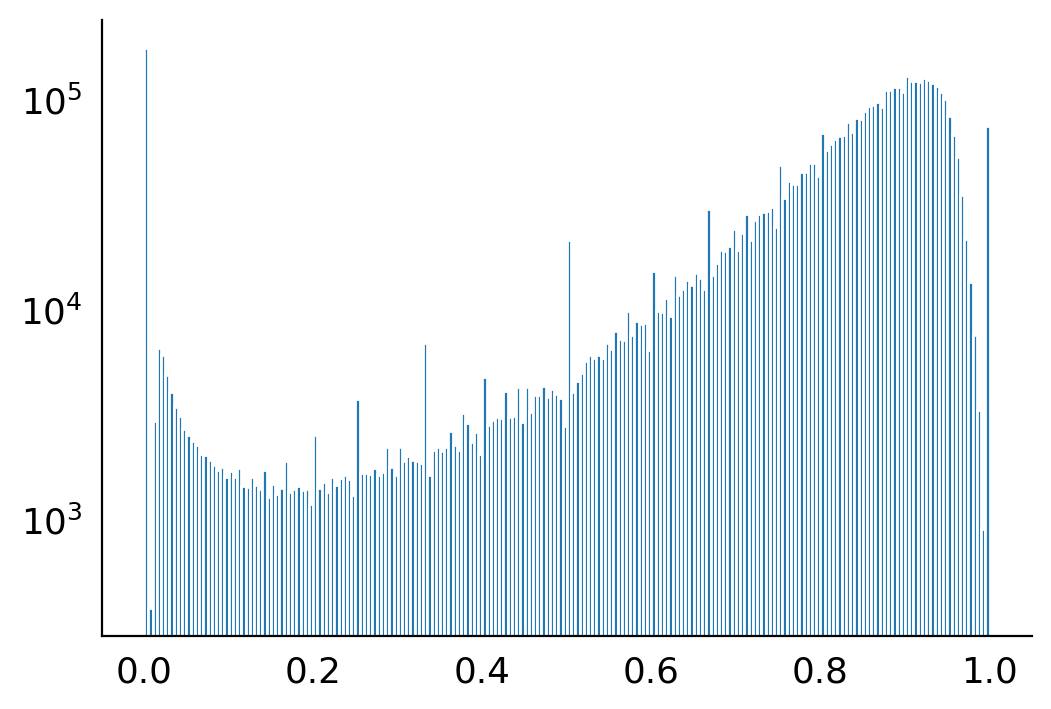

In [22]:
fig,ax=plt.subplots()
plt.hist(df_intersect_2['rate_new'],bins=200);
plt.yscale('log')

Text(0, 0.5, 'Window reads sum, Rate')

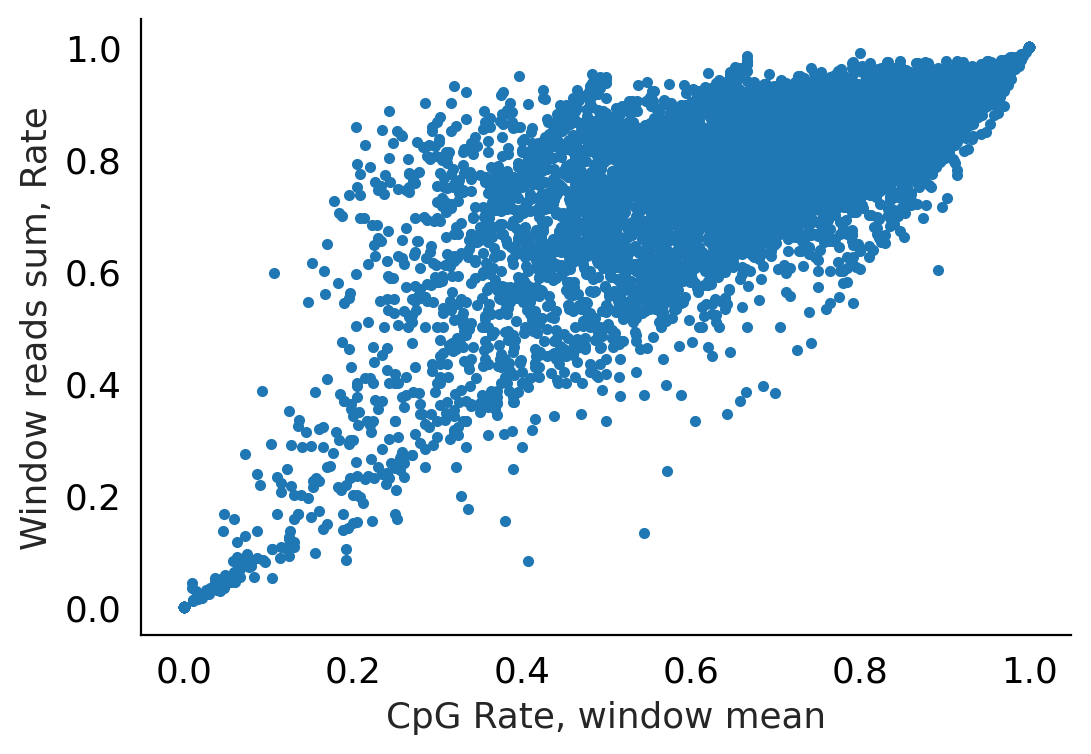

In [23]:
plt.plot(df_intersect_2['rate'][:10000],df_intersect_2['rate_new'][:10000],'.')
plt.xlabel('CpG Rate, window mean')
plt.ylabel('Window reads sum, Rate')

In [24]:
thresh_low = 0.1
thresh_high = 0.6
read_N_cutoff=3
annotation_name='mouse_LK' # This needs to be changed, dataset-specific
merge=True


print(f'------------- thresh_high = {thresh_high}, thresh_low = {thresh_low} -------------')

df_intersect_3=df_intersect_2[((df_intersect_2['rate_new']>=thresh_low) & (df_intersect_2['rate_new']<=thresh_high) & (df_intersect_2['total_N']>=read_N_cutoff))]
df_intersect_3['Start']=df_intersect_3['Start']-1

df_bed=methyltree.analysis.generate_feature_bed_file_from_signal_peaks(df_intersect_3,signal_key='rate_new',merge=merge,annotation_name=annotation_name)

print(f'length {len(df_bed)}')

final_annotation=f'neutral_thresh_{annotation_name}_readNcutoff_{read_N_cutoff}_{thresh_low}_{thresh_high}_500bp'
bed_dir=f"{current_directory}/metadata/mouse_LK_all/bed_files/{final_annotation}.bed"
print(f'Annotation name: {final_annotation}')

## Run this code to save the bed file
df_bed.to_csv(f"{bed_dir}", sep="\t", index=0, header=None)

------------- thresh_high = 0.6, thresh_low = 0.1 -------------
length 277530
Annotation name: neutral_thresh_mouse_LK_readNcutoff_3_0.1_0.6_500bp


# Fast matrix generation with MethScan

In [31]:
out_dir=f'{data_path}/out_dir'
methscan_data_dir=f'{data_path}/methscan'
compact_file_dir=f'{out_dir}/compact_data'

## Generate compact data for fast access 
(need to be done only once, regardless of which annotation you use)

In [32]:
#selected_sample_list=list(df_sample['sample'].unique())
selected_sample_list=[x.split('.tsv.gz')[0] for x in os.listdir(f'{data_path}/met/cpg_level') if '.gz' in x]
len(selected_sample_list)
print(f"{datetime.now()} (hour:min:s).\n")

2024-10-21 09:37:07.916992 (hour:min:s).



In [33]:
input_files=[f'{data_path}/met/cpg_level/{x}.tsv.gz' for x in selected_sample_list]
recompute=False
# compact the data
if (not os.path.exists(f'{compact_file_dir}/chr1.npz')) or recompute:
    methscan.prepare.prepare(input_files,compact_file_dir,input_format='1:2:3:4u:\t:1',round_sites=True,chunksize=1e7)
    # smooth the data (we do not need this, but this is required by this package)
    methscan.smooth.smooth(compact_file_dir,bandwidth=1000, use_weights=True)
    
if os.path.exists(f'{compact_file_dir}/1.npz'):
    raise ValueError('chromosome name in cpg_level files should be changed to chr1 format')

## Generate the cell-by-region matrix

In [34]:
method='bulk' #'single_CpG' #
if method=='single_CpG':
    annotation=f'{genome_reference}_singleCpG_mergedStrand' # exist under: /storage/wangshouwenLab/shared_folder/features/genomic_contexts_rjfu
else: # use regions
    annotation='neutral_thresh_mouse_LK_readNcutoff_3_0.1_0.6_500bp'
matrix_dir=f'{methscan_data_dir}/matrix/{annotation}'
print(f"{datetime.now()} (hour:min:s).\n")

2024-10-21 09:37:53.866084 (hour:min:s).



In [35]:
region_dir=f"{current_directory}/metadata/mouse_LK_all/bed_files/{annotation}.bed"
recompute=False
with open(region_dir,'r') as regions:
    if (not os.path.exists(f'{matrix_dir}/matrix.mtx.gz')) or recompute:
        methscan.matrix.matrix_sparse(compact_file_dir, regions, matrix_dir, threads=-1)

loading chromosome chr1 from /storage/wangshouwenLab/limited_shared_folder/MethylTtree_notebook/metadata/mouse_LK_all/downstream_R/all_data/out_dir/compact_data/chr1.npz ...
extracting methylation for regions on chromosome chr1 ...
Appending data to sparse matrix at /storage/wangshouwenLab/limited_shared_folder/MethylTtree_notebook/metadata/mouse_LK_all/downstream_R/all_data/methscan/matrix/neutral_thresh_mouse_LK_readNcutoff_3_0.1_0.6_500bp/matrix.mtx.gz ...
loading chromosome chr10 from /storage/wangshouwenLab/limited_shared_folder/MethylTtree_notebook/metadata/mouse_LK_all/downstream_R/all_data/out_dir/compact_data/chr10.npz ...
extracting methylation for regions on chromosome chr10 ...
Appending data to sparse matrix at /storage/wangshouwenLab/limited_shared_folder/MethylTtree_notebook/metadata/mouse_LK_all/downstream_R/all_data/methscan/matrix/neutral_thresh_mouse_LK_readNcutoff_3_0.1_0.6_500bp/matrix.mtx.gz ...
loading chromosome chr11 from /storage/wangshouwenLab/limited_shared_

## Generate the adata

In [40]:
read_cutoff=1
exclude_sex=0
min_coverage=2
groupby='tissue'
selected='LK'
save_data_des=f'{groupby}_{selected}_{annotation}_readcutoff{read_cutoff}_minCov{min_coverage}_met_ExcludeSex{exclude_sex}'

In [41]:
## load the full data
print(f"{datetime.now()} (hour:min:s).\n")
df_data=methyltree.analysis.load_methscan_matrix(matrix_dir)

2024-10-21 09:46:58.874848 (hour:min:s).



In [42]:
## select a subset of cells
sample_index_map=methyltree.analysis.get_methscan_sample_index_map(compact_file_dir)
selected_row=df_sample[(df_sample[groupby]==selected) & df_sample['HQ']]['sample'].map(sample_index_map).to_list()
df_data_sub=df_data[df_data['row'].isin(selected_row)]

In [43]:
adata=methyltree.analysis.generate_adata_from_methscan_matrix(df_data_sub,matrix_dir,read_cutoff=read_cutoff)
methyltree.analysis.update_sample_info_on_adata(adata,df_sample)
adata=methyltree.analysis.filter_adata(adata,exclude_sex=exclude_sex,exclude_chrM=True,min_cell_coverage=min_coverage)
print(f"{datetime.now()} (hour:min:s).\n")

full adata shape: (539, 277530)
adata shape removing regions covering less than 2 cells : (539, 277184)
2024-10-21 09:47:19.714833 (hour:min:s).



In [44]:
adata

View of AnnData object with n_obs × n_vars = 539 × 277184
    obs: 'cell', 'pass_accQC', 'pass_metQC', 'id_met', 'id_acc', 'lineage', 'stage', 'nCG', 'n_meth', 'met_rate', 'TSS_score', 'plate', 'HQ', 'plate_id', 'chrM_rate', 'CpG_rate', 'CHG_rate', 'CHH_rate', 'Mapping_efficiency', 'tissue'

## Optional: add RNA and LARRY infomation in df_sample

In [77]:
adata_RNA_LARRY = sc.read(f'{current_directory}/metadata/mouse_LK_all/RNA_and_LARRY/mouse_LK_RNA_and_LARRY.h5ad')

In [79]:
df_sample['plate_barcode']=df_sample['sample'].apply(lambda x: x.split('_')[-1])

In [80]:
Lime_barcode = methyltree.metadata.mapping_from_plate_barcode_to_Lime_barcode(
    df_sample["plate_barcode"]
)

df_sample["Lime_barcode"] = Lime_barcode

In [81]:
def assign_id_rna(row):
    if row['cell'].startswith('LK_DNA_1_'):
        return 'LK_RNA_1_' + row['Lime_barcode']
    elif row['cell'].startswith('LK_DNA_2_'):
        return 'LK_RNA_2_' + row['Lime_barcode']
    elif row['cell'].startswith('LK_DNA_3_'):
        return 'LK_RNA_3_' + row['Lime_barcode']
    elif row['cell'].startswith('LK_DNA_4_'):
        return 'LK_RNA_4_' + row['Lime_barcode']
    elif row['cell'].startswith('LK_DNA_5_'):
        return 'LK_RNA_5_' + row['Lime_barcode']
    else:
        return 'LK_RNA_6_' + row['Lime_barcode']

df_sample['id_rna'] = df_sample.apply(assign_id_rna, axis=1)

In [82]:
df_clone_fate=cs.tl.clone_statistics(adata_RNA_LARRY,joint_variable='state_info',
    display_clone_stat=True,)
df_clone_fate

                  clone_N  clone_fraction
state_info                               
Ba                      9        0.120000
Ba,Eos                  1        0.013333
Ba,Ma                   3        0.040000
Ba,Ma,nan               1        0.013333
Ba,Neu                  1        0.013333
...                   ...             ...
Mk,Ba,Er                1        0.013333
Mk,Er                   6        0.080000
Mk,Neu,Eos,Er           1        0.013333
Neu                     3        0.040000
Neu,Neu-Mo,Dc-Mo        1        0.013333

[22 rows x 2 columns]
-----------
            cell_N  clonal_cell_fraction
state_info                              
Ba             183              0.347249
Dc-Mo           24              0.045541
Eos             15              0.028463
Er              79              0.149905
Ma              93              0.176471
Mk              35              0.066414
Neu             39              0.074004
Neu-Mo          25              0.047438
nan      

,clone_id,clone_size,state_info,state_info_N
0,0,56,Ba,1
1,1,10,"Mk,Er",2
2,2,1,Ma,1
3,3,1,Mk,1
4,4,2,Dc-Mo,1
...,...,...,...,...
70,70,4,"Mk,Er",2
71,71,2,Dc-Mo,1
72,72,2,Mk,1
73,73,15,"Mk,Neu,Eos,Er",4


In [83]:
cs.tl.add_clone_id_for_each_cell(adata_RNA_LARRY)

add information at obs['clone_id']


In [84]:
adata_rna_tmp = adata_RNA_LARRY[adata_RNA_LARRY.obs_names.isin(df_sample["id_rna"])]
df_sample = df_sample.set_index("id_rna")
df_UMAP = pd.DataFrame(
    {
        "id_rna": adata_rna_tmp.obs_names,
        "UMAP_rna_x": adata_rna_tmp.obsm["X_umap"][:, 0],
        "UMAP_rna_y": adata_rna_tmp.obsm["X_umap"][:, 1],
    }
).set_index("id_rna")
df_sample.loc[adata_rna_tmp.obs_names, "celltype"] = adata_rna_tmp.obs[
    "cell_type"
].astype(str)
df_sample.loc[adata_rna_tmp.obs_names, "UMAP_rna_x"] = df_UMAP["UMAP_rna_x"]
df_sample.loc[adata_rna_tmp.obs_names, "UMAP_rna_y"] = df_UMAP["UMAP_rna_y"]

In [87]:

def add_prefix(clone_id):
    if clone_id == '':
        return np.nan
    else:
        return 'clone_' + str(clone_id)

# 应用这个函数到 clone_id 列
df_sample.loc[adata_rna_tmp.obs_names, "clone_id"] = adata_rna_tmp.obs["clone_id"].apply(add_prefix)


In [89]:
df_sample=df_sample.reset_index()
methyltree.metadata.backup_and_save_sample_info(df_sample,data_path)

## MethylTree analysis

Perform additional filtering (min_coverage, exclude_sex) 

use provided adata
adata shape:  (539, 277184)
update sample
X_similarity_correlation_fast_raw not found in adata.obsm
re-compute similarity matrix
Use correlation_fast for similarity
-------zero centered--------


100%|██████████| 539/539 [02:53<00:00,  3.11it/s]


duration: 175.65420579910278
correct similarity: outer loop 0;  current epsilon 0.05
Use fast/analytical correction method


  2%|▏         | 20/1000 [00:00<00:05, 193.79it/s]


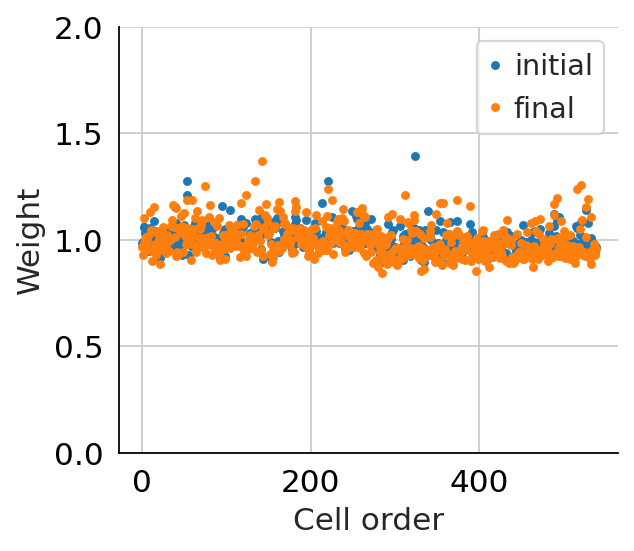

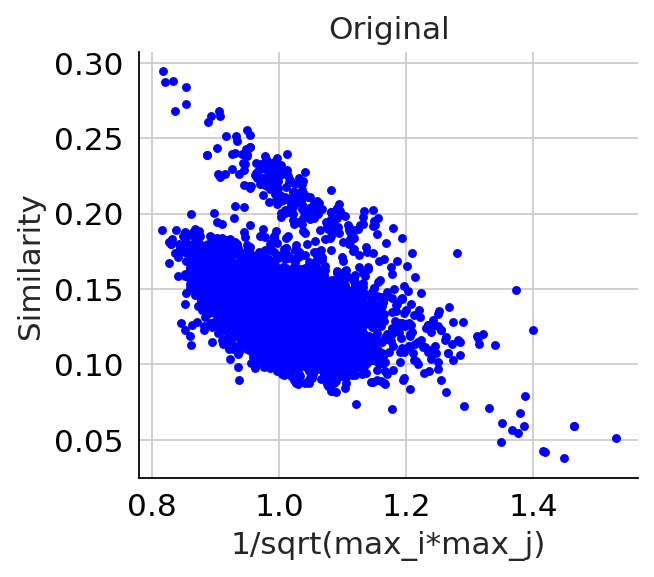

std: 0.019


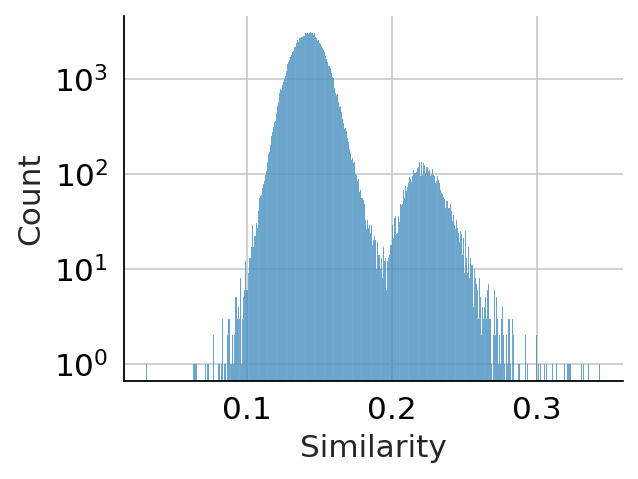

Reconstruction method: UPGMA
      clone  clone_size  accuracy  continuity  entropy  wassertein  \
0   clone_0          56       1.0         1.0      0.0         0.0   
1   clone_1          10       1.0         1.0      0.0         0.0   
2  clone_10           2       1.0         1.0      0.0         0.0   
3  clone_12           4       1.0         1.0      0.0         0.0   
4  clone_13           3       1.0         1.0      0.0         0.0   

   random_accuracy  random_continuity  random_entropy  random_wassertein  
0         0.044643           0.135714        0.957171           0.782143  
1         0.000000           0.100000        1.000000           0.810000  
2         0.000000           0.500000        1.000000           0.500000  
3         0.050000           0.275000        0.975000           0.725000  
4         0.000000           0.333333        1.000000           0.666667  
mean continuity: 1.0
mean accuracy: 1.0
mean entropy: 0.0
mean wassertein: 0.0
mean random_continuit

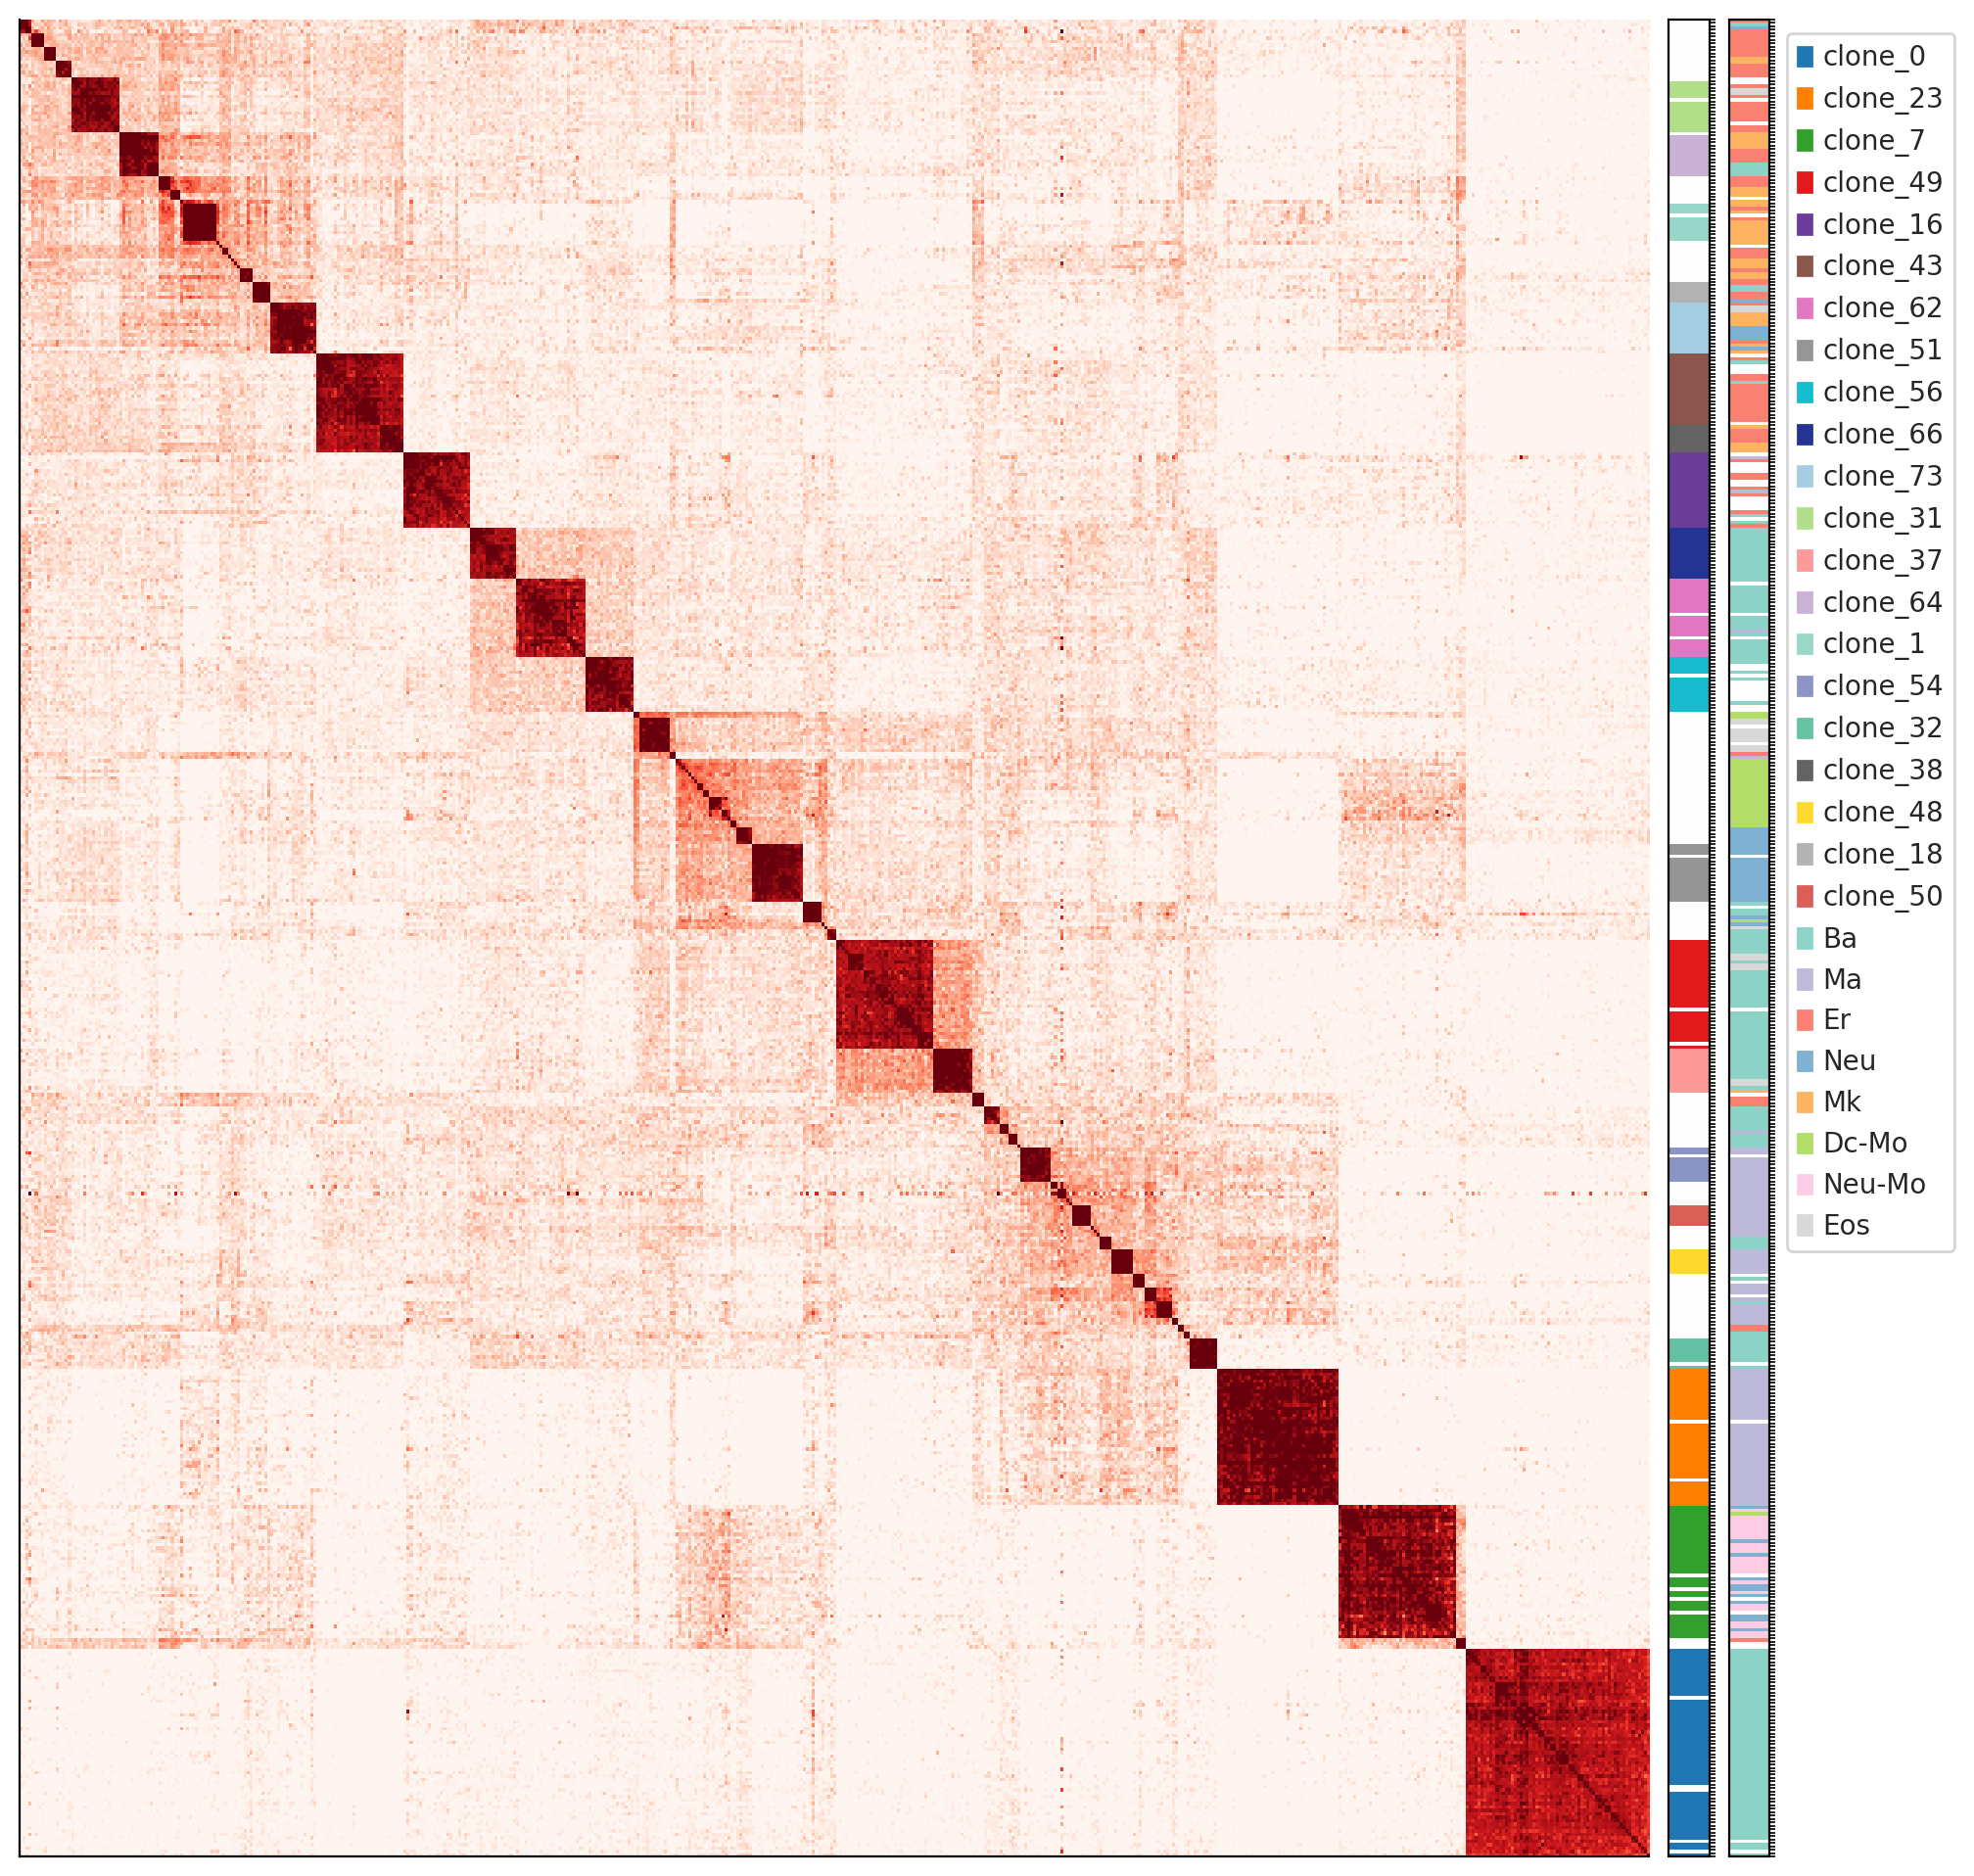

In [92]:
adata, statu_out = methyltree.analysis.comprehensive_lineage_analysis(
    out_dir,
    data_path,
    save_data_des=None,
    clone_key='clone_id',
    adata_orig=adata,
    compute_similarity=False,  # use pre-computed similarity
    similarity_method='correlation_fast',
    remove_celltype_signal=False,
    similarity_normalize=False,
    similarity_correction=True,
    perform_coarse_graining=False,
    fig_dir=None,
    heatmap_vmax_percentile=99.5,
    heatmap_vmin_percentile=40,
    heatmap_additional_key_list=['celltype']
)


In [93]:
adata.write_h5ad(f'{out_dir}/{save_data_des}.h5ad')